Metin veya konuşma biçiminde cümleler biçiminde yapılan girdileri anlamak için bilgisayar yazılımını kullanan bir yapay zeka dalıdır.

1. Text Preprocessing
2. Text Visualization
3. Sentiment Analysis
4. Feature Engineering
5. Sentiment Modeling

In [1]:

# !pip install nltk
# !pip install textblob
# !pip install wordcloud
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1. Text Preprocessing

In [2]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


Normalizing Case Folding(Küçük harfe çevrilmesi)

In [3]:
df["reviewText"] = df['reviewText'].str.lower()

Punctuations (Noktalama işaretlerinin kaldırılması)

In [4]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

Numbers (Sayıların kaldırılması)

In [5]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

Stopwords (Çok sık kullanılan kelimelerin kaldırılması)

In [6]:
import nltk
# nltk.download('stopwords')
sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


Rarewords(Çok az kullanılan kelimelerin kaldırılması)

In [7]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))


Tokenization (Kelime ayrıştırma)

In [8]:
#nltk.download("punkt")

df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

Lemmatization(Kelime köklerinin bulunması)

In [13]:
#nltk.download('wordnet')


In [14]:
import nltk
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# 2. Text Visualization

Terim Frekanslarının Hesaplanması

In [15]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)


,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


Barplot

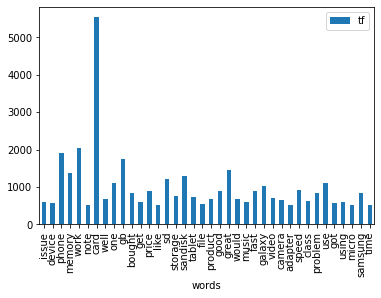

In [16]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

Wordcloud

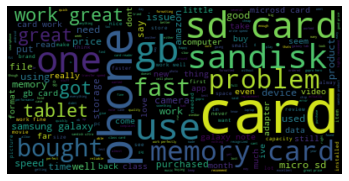

In [17]:
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

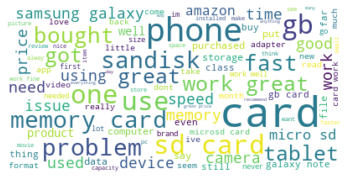

In [18]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

Şablonlara Göre Wordcloud

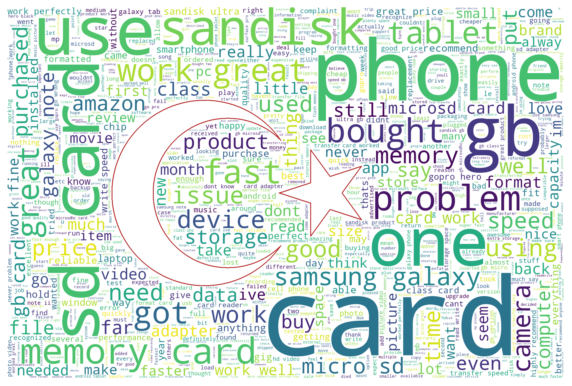

In [20]:
tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()